In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)

In [2]:
seq_length = 7
data_dim = 4
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 1000

In [3]:
data_path = "../../Test_Samples/Naver_stock_without_date.csv"   # Naver stock data in the past

header = np.loadtxt(data_path, max_rows=1, delimiter=',', dtype=str)
print(header)

['Open' 'High' 'Low' 'Close']


In [4]:
data = np.loadtxt(data_path, skiprows=1, delimiter=",")

print(len(data))
print(data)

490
[[155400. 156400. 154000. 154200.]
 [153400. 153400. 150000. 151000.]
 [152000. 153400. 150800. 151400.]
 ...
 [313000. 322000. 310500. 322000.]
 [324500. 325500. 312000. 314000.]
 [308500. 314500. 303500. 313500.]]


In [54]:
data.shape
#data = data[::-1]      # reverse order : 제공되는 Data의 시간 순서에 따라 필요시 진행

(490, 4)

In [5]:
train_size = int(len(data) * 0.7)
train_set = data[0:train_size]
test_set = data[train_size - seq_length:]

In [6]:
print(len(train_set))
train_set

343


array([[155400., 156400., 154000., 154200.],
       [153400., 153400., 150000., 151000.],
       [152000., 153400., 150800., 151400.],
       ...,
       [180000., 182000., 178000., 180500.],
       [182500., 187000., 181500., 187000.],
       [182000., 183500., 179000., 183000.]])

In [7]:
print(len(test_set))

154


In [8]:
# column 별 min, max 연산 방법
np.min(test_set, 0)                               # 0은 column 방향 계산

array([141500., 149500., 135000., 143000.])

In [9]:
def minmax_scaler(data):                                # Data nomalization
    numerator = data - np.min(data, 0)                  # 각 column의 최소값을 기준으로 data shift
    denominator = np.max(data, 0) - np.min(data, 0)     # 각 column의 최대-최소 구간 계산
    return numerator / denominator                     # shifted max를 min-max구간으로 normalize 

def build_dataset(time_series, seq_length):             # Dataset 만들기 함수
    dataX = []                                          ## seq_length 기간 동안 시작, 종료 가격, 거래량 등을
    dataY = []                                          ## 하루씩 Data를 Shift하면서 _x dataset 만들고,
    for i in range(0, len(time_series) - seq_length):  ## 'seq_length + 1'의 가격으로 _y 예측값 dataset을 구성
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]          # _y는 예측할 가격만 필요하므로 '해당값[-1]'만 선택
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [10]:
# 예시 arrary로 _x와 _y의 date 구성 review
a=np.arange(6)+np.arange(0, 51, 10)[:, np.newaxis]
print('whole \n', a)
print('2nd col.\n', a[0:3,1])

_i=0
_length=3
print('_x \n', a[_i:_i+_length,:])
print('_y \n', a[_i+_length,[-1]])     # _y는 예측할 가격만 필요하므로 다음날 '해당값[-1]'만 선택

whole 
 [[ 0  1  2  3  4  5]
 [10 11 12 13 14 15]
 [20 21 22 23 24 25]
 [30 31 32 33 34 35]
 [40 41 42 43 44 45]
 [50 51 52 53 54 55]]
2nd col.
 [ 1 11 21]
_x 
 [[ 0  1  2  3  4  5]
 [10 11 12 13 14 15]
 [20 21 22 23 24 25]]
_y 
 [35]


In [11]:
# data normalization
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# dataset 만들기
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)


# torch 텐서 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

[[0.60853659 0.59518072 0.62893082 0.59254658]
 [0.58414634 0.55903614 0.57861635 0.55279503]
 [0.56707317 0.55903614 0.58867925 0.55776398]
 [0.54268293 0.54939759 0.56603774 0.54037267]
 [0.55243902 0.56144578 0.57358491 0.55279503]
 [0.57682927 0.55662651 0.58616352 0.55279503]
 [0.55243902 0.54457831 0.57106918 0.53291925]] -> [0.53291925]
[[0.58414634 0.55903614 0.57861635 0.55279503]
 [0.56707317 0.55903614 0.58867925 0.55776398]
 [0.54268293 0.54939759 0.56603774 0.54037267]
 [0.55243902 0.56144578 0.57358491 0.55279503]
 [0.57682927 0.55662651 0.58616352 0.55279503]
 [0.55243902 0.54457831 0.57106918 0.53291925]
 [0.53536585 0.51325301 0.55597484 0.53291925]] -> [0.59503106]
[[0.56707317 0.55903614 0.58867925 0.55776398]
 [0.54268293 0.54939759 0.56603774 0.54037267]
 [0.55243902 0.56144578 0.57358491 0.55279503]
 [0.57682927 0.55662651 0.58616352 0.55279503]
 [0.55243902 0.54457831 0.57106918 0.53291925]
 [0.53536585 0.51325301 0.55597484 0.53291925]
 [0.55487805 0.57349398 0.

 [0.20121951 0.18072289 0.20125786 0.17391304]] -> [0.14285714]
[[0.16463415 0.15662651 0.16352201 0.14285714]
 [0.16463415 0.14457831 0.16981132 0.14285714]
 [0.15243902 0.15060241 0.16981132 0.14285714]
 [0.16463415 0.1686747  0.18867925 0.17391304]
 [0.20121951 0.18674699 0.19496855 0.18012422]
 [0.20121951 0.18072289 0.20125786 0.17391304]
 [0.17682927 0.1626506  0.16981132 0.14285714]] -> [0.16770186]
[[0.16463415 0.14457831 0.16981132 0.14285714]
 [0.15243902 0.15060241 0.16981132 0.14285714]
 [0.16463415 0.1686747  0.18867925 0.17391304]
 [0.20121951 0.18674699 0.19496855 0.18012422]
 [0.20121951 0.18072289 0.20125786 0.17391304]
 [0.17682927 0.1626506  0.16981132 0.14285714]
 [0.15853659 0.15662651 0.16352201 0.16770186]] -> [0.16149068]
[[0.15243902 0.15060241 0.16981132 0.14285714]
 [0.16463415 0.1686747  0.18867925 0.17391304]
 [0.20121951 0.18674699 0.19496855 0.18012422]
 [0.20121951 0.18072289 0.20125786 0.17391304]
 [0.17682927 0.1626506  0.16981132 0.14285714]
 [0.15853

 [0.57317073 0.61445783 0.61006289 0.62732919]] -> [0.57763975]
[[0.56097561 0.56024096 0.56603774 0.56521739]
 [0.54878049 0.57228916 0.58490566 0.59006211]
 [0.56707317 0.56024096 0.59748428 0.57142857]
 [0.56097561 0.55421687 0.58490566 0.57763975]
 [0.55487805 0.56024096 0.59119497 0.57142857]
 [0.57317073 0.61445783 0.61006289 0.62732919]
 [0.63414634 0.61445783 0.60377358 0.57763975]] -> [0.59627329]
[[0.54878049 0.57228916 0.58490566 0.59006211]
 [0.56707317 0.56024096 0.59748428 0.57142857]
 [0.56097561 0.55421687 0.58490566 0.57763975]
 [0.55487805 0.56024096 0.59119497 0.57142857]
 [0.57317073 0.61445783 0.61006289 0.62732919]
 [0.63414634 0.61445783 0.60377358 0.57763975]
 [0.56707317 0.57228916 0.59748428 0.59627329]] -> [0.71428571]
[[0.56707317 0.56024096 0.59748428 0.57142857]
 [0.56097561 0.55421687 0.58490566 0.57763975]
 [0.55487805 0.56024096 0.59119497 0.57142857]
 [0.57317073 0.61445783 0.61006289 0.62732919]
 [0.63414634 0.61445783 0.60377358 0.57763975]
 [0.56707

 [0.47814208 0.46306818 0.50847458 0.49162011]] -> [0.54469274]
[[0.53825137 0.53125    0.51412429 0.46368715]
 [0.50273224 0.49715909 0.53672316 0.52513966]
 [0.51092896 0.49147727 0.5480226  0.50837989]
 [0.51092896 0.48863636 0.50847458 0.46089385]
 [0.4726776  0.48579545 0.51977401 0.5       ]
 [0.47814208 0.46306818 0.50847458 0.49162011]
 [0.50819672 0.52556818 0.54237288 0.54469274]] -> [0.52793296]
[[0.50273224 0.49715909 0.53672316 0.52513966]
 [0.51092896 0.49147727 0.5480226  0.50837989]
 [0.51092896 0.48863636 0.50847458 0.46089385]
 [0.4726776  0.48579545 0.51977401 0.5       ]
 [0.47814208 0.46306818 0.50847458 0.49162011]
 [0.50819672 0.52556818 0.54237288 0.54469274]
 [0.53825137 0.53125    0.56779661 0.52793296]] -> [0.56424581]
[[0.51092896 0.49147727 0.5480226  0.50837989]
 [0.51092896 0.48863636 0.50847458 0.46089385]
 [0.4726776  0.48579545 0.51977401 0.5       ]
 [0.47814208 0.46306818 0.50847458 0.49162011]
 [0.50819672 0.52556818 0.54237288 0.54469274]
 [0.53825

In [12]:
trainX_tensor.shape             # 343개 train data에서 7개 묶음으로 1개씩 shift하여 만든 336개 data
                                # 이 1개가 위에서 (7 x 4) 크기의 행열임.

torch.Size([336, 7, 4])

In [13]:
# RNN(LSTM) output Review
input_dim = 4
hidden_dim = 10
layers=1


test=torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
out, _= test(trainX_tensor)

print('LSTM 연산 결과 텐서 크기 : ' ,out.shape)     # (batch 크기 x seq.문장 길이 x 은닉층 크기)
print(out[:,-1].shape)                              # seq. 마지막 hidden state 선택   (batch 크기 x 은닉층 크기)
print(out[:,-1])         

LSTM 연산 결과 텐서 크기 :  torch.Size([336, 7, 10])
torch.Size([336, 10])
tensor([[-0.1275,  0.0244, -0.0740,  ...,  0.0324, -0.0214,  0.1224],
        [-0.1285,  0.0251, -0.0745,  ...,  0.0326, -0.0237,  0.1223],
        [-0.1285,  0.0235, -0.0736,  ...,  0.0336, -0.0246,  0.1223],
        ...,
        [-0.1258, -0.0085, -0.0376,  ...,  0.0305,  0.0188,  0.1537],
        [-0.1257, -0.0083, -0.0386,  ...,  0.0311,  0.0184,  0.1546],
        [-0.1260, -0.0095, -0.0375,  ...,  0.0314,  0.0176,  0.1542]],
       grad_fn=<SelectBackward>)


In [14]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)
    def forward(self, x):
        x, _status = self.rnn(x)
        x = x[:, -1]                       # seq. 마지막 hidden state 선택
        x = self.fc(x)
        return x

In [15]:
net = Net(data_dim, hidden_dim, output_dim, 1)

# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

In [17]:
# Training
for i in range(iterations+1):
        optimizer.zero_grad()
        outputs = net(trainX_tensor)
        loss = criterion(outputs, trainY_tensor)
        loss.backward()
        optimizer.step()
        if i % 200 == 0:
            print("[{}/{}]  loss is {:.4f} ".format(i, iterations, loss.item()))

[0/1000]  loss is 0.0011 
[200/1000]  loss is 0.0011 
[400/1000]  loss is 0.0010 
[600/1000]  loss is 0.0010 
[800/1000]  loss is 0.0012 
[1000/1000]  loss is 0.0010 


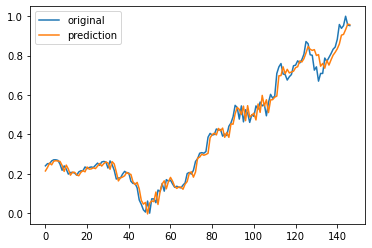

In [18]:
plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()

* Reference

   https://www.edwith.org/boostcourse-dl-pytorch/lecture/43778/